#Imports

In [108]:
import nltk
import numpy as np
from bs4 import BeautifulSoup
import regex as re
import io
import pandas as pd
import math
import random
import os
import string

In [109]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [110]:
!pip install pyplutchik==0.0.7
!git clone https://github.com/avichaychriqui/HeBERT.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'HeBERT' already exists and is not an empty directory.


In [111]:
# !pip uninstall transformers -y
!pip install transformers==4.28.0
!pip install accelerate -U
!pip install hebrew_tokenizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [112]:
from nltk.tokenize import word_tokenize
from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers.pre_tokenizers import Whitespace
from transformers import AutoTokenizer, AutoModelForMaskedLM, LineByLineTextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments
from transformers import pipeline
import hebrew_tokenizer as ht

#Corpus creation

In [113]:
# Load the excel file into a pandas dataframe
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Final_Project/bible.xlsx')
bible_array=np.array(df)

In [114]:
def clean_bible(bible_line):
    bible_line = BeautifulSoup(bible_line,"lxml").get_text()
    #remove the {ס} and replace with space
    bible_line=re.sub(r'\{.*?\}', ' ', bible_line)
    #remove the [בראשית א א] and replace with space
    #remove double spaces
    bible_line = re.sub(r" +",' ',bible_line)
    bible_line=re.sub(r'\[.*?\]', '\n', bible_line)
    #split based on \n so each line is pasoc
    bible_line=  bible_line.split('\n')
    return bible_line

In [115]:
bible_array_clean=clean_bible(str(bible_array[0]))

In [116]:
bible_clean = [clean_bible(str(bible_line)) for bible_line in bible_array]

<ipython-input-114-3f6751898d2e>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  bible_line = BeautifulSoup(bible_line,"lxml").get_text()


In [117]:
def flatten_list(nested_list):
    flat_list=[]
    for sub_list in nested_list:
        flat_list.extend(sub_list)
    return flat_list

In [118]:
flat_bible = flatten_list(bible_clean)

In [119]:
re.sub(pattern="]",string=flat_bible[5],repl="")

" ויקרא אל_ים לאור יום ולחשך קרא לילה ויהי ערב ויהי בקר יום אחד. '"

In [120]:
bible=[]
for element in flat_bible:
    bible.append(re.sub(pattern="]",string=element,repl=""))

In [121]:
# by default it doesn't return whitespaces but it can be done easily
tokens = ht.tokenize(bible[2], with_whitespaces=False)  # notice the with_whitespace flag
# for grp, token, token_num, (start_index, end_index) in tokens:
#     print('{}, {}'.format(grp, token))

trying to create a corpus to be used later for further NLP opreations this is the generic version igrnoring the fact that we use hebew

In [122]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [123]:

tokenized_list = [word_tokenize(text) for text in bible]

In [124]:
corpus = nltk.Text(word for text in tokenized_list for word in text)

I initialize a new Tokenizer object using the WordPiece model. I set the unk_token to [UNK], which is a special token used to represent out-of-vocabulary words.

In [125]:


tokenizer = Tokenizer(WordPiece(unk_token="[UNK]"))

# Optional: you can add a pre-tokenizer to split sentences into words
tokenizer.pre_tokenizer = Whitespace()

# Add your list of strings to the tokenizer
tokenizer.add_tokens(bible)

# Encode the strings into a list of token IDs
encoded_list = [tokenizer.encode(text) for text in bible]

# Convert the encoded list into a list of strings
corpus = [encoded.tokens for encoded in encoded_list]

#normal model check

In [126]:

# Load the HeBERT tokenizer and model
model_name = "avichr/heBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForMaskedLM.from_pretrained(model_name)

# Load your custom corpus
corpus_file = "/content/drive/MyDrive/Colab Notebooks/Final_Project/corpus.txt"

# Create a dataset from your corpus
dataset = LineByLineTextDataset(
    tokenizer=tokenizer,
    file_path=corpus_file,
    block_size=128,
)


/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:119: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


In [127]:

# Create a data collator to prepare the data for training
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15,
)


In [128]:

# Define the training arguments
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Colab Notebooks/Final_Project/trained_model",
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=32,
    save_steps=500,
    save_total_limit=2,
    prediction_loss_only=True,
)


In [129]:
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Colab Notebooks/Final_Project/trained_model",
    save_strategy="epoch",
    save_total_limit=3,
)
    

# Create a Trainer object to train the model
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset,
    tokenizer=tokenizer,
    )

# Fine-tune the model on your custom corpus
trainer.train()


# Evaluate the model on a separate test set
# ...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


TrainOutput(global_step=3, training_loss=0.953685442606608, metrics={'train_runtime': 68.0125, 'train_samples_per_second': 0.044, 'train_steps_per_second': 0.044, 'total_flos': 197403609600.0, 'train_loss': 0.953685442606608, 'epoch': 3.0})

In [130]:
save_total_limit='3'
path = "/content/drive/MyDrive/Colab Notebooks/Final_Project/trained_model"
os.path.isdir(path)
os.chdir(path=path)
print(os.listdir())
for i in range(len(os.listdir())-1):
    if "checkpoint-"+save_total_limit in os.listdir()[i]:
        path+='/'+os.listdir()[i]+'/'
if os.path.isdir(path):
    trained_model=path
    print(trained_model)


['runs', 'checkpoint-1', 'checkpoint-2', 'checkpoint-3', 'HeBERT', 'tests_results.csv']
/content/drive/MyDrive/Colab Notebooks/Final_Project/trained_model/checkpoint-3/


In [131]:
# import os
# path = "/content/drive/MyDrive/Colab Notebooks/Final_Project/trained_model/runs/"
# os.path.isdir(path)
# os.chdir(path=path)
# path+=os.listdir()[-1]+"/"
# print(path)
# os.path.isdir(path)
# os.chdir(path=path)
# path+=os.listdir()[1]
# print(path)
# print(os.path.isdir(path))
# if os.path.isfile(path):
#     trained_model=path
#     print(trained_model)

In [132]:
from transformers import AutoConfig

model_name = "avichr/heBERT"
config = AutoConfig.from_pretrained(model_name)

# Save the configuration file to disk
config.save_pretrained("/content/drive/MyDrive/Colab Notebooks/Final_Project/trained_model/HeBERT/config.json")
print(tokenizer)

BertTokenizerFast(name_or_path='avichr/heBERT', vocab_size=30000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)


In [133]:

# Load the tokenizer for your fine-tuned model
# tokenizer = AutoTokenizer.from_pretrained("./results")
# path = "/content/drive/MyDrive/Colab Notebooks/Final_Project/trained_model"
# Use the fill-mask pipeline with your fine-tuned model
fill_mask = pipeline(
    "fill-mask",
    model=trained_model,
    tokenizer=tokenizer
)


**now that we have a corpus trained hebert model lets only take 90% of the data and train on that.once its trained let's run it on the next 10%.**

#Train and Test prep


In [134]:
def split_corpus(corpus):
    corpus_str = str(corpus)
    len_tenth = math.ceil(len(corpus)/10)
    test_corpus = corpus[0:len_tenth]
    training_corpus = corpus[len_tenth:-1]
    return test_corpus,training_corpus

In [135]:
random.shuffle(corpus)
test_corpus,training_corpus= split_corpus(corpus)

In [136]:
corpus_test_str = str(test_corpus)
corpus_training_str = str(training_corpus)

In [137]:
file = open('/content/drive/MyDrive/Colab Notebooks/Final_Project/corpus_training.txt','w')
file.writelines(corpus_training_str)
file.close()

In [138]:
file = open('/content/drive/MyDrive/Colab Notebooks/Final_Project/corpus_test.txt','w')
file.writelines(corpus_test_str)
file.close()

now we run training on the 90% training corpus

In [139]:
def train_model(model_name):
    # Load the HeBERT tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForMaskedLM.from_pretrained(model_name)

    # Load your custom corpus
    corpus_file = "/content/drive/MyDrive/Colab Notebooks/Final_Project/corpus_training.txt"

    # Create a dataset from your corpus
    dataset = LineByLineTextDataset(
        tokenizer=tokenizer,
        file_path=corpus_file,
        block_size=128,
    )
    # Create a data collator to prepare the data for training
    data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15,
    )

    # Define the training arguments
    training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Colab Notebooks/Final_Project/trained_model",
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=32,
    save_steps=500,
    save_total_limit=2,
    prediction_loss_only=True,
    )

    saved_checkpoints=3
    training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Colab Notebooks/Final_Project/trained_model",
    save_strategy="epoch",
    save_total_limit=3,
    )
    # Create a Trainer object to train the model
    trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset,
    tokenizer=tokenizer,
    )
    # Fine-tune the model on your custom corpus
    trainer.train()


   




#Train model

In [140]:
save_total_limit='3'
path = "/content/drive/MyDrive/Colab Notebooks/Final_Project/trained_model"
os.path.isdir(path)
os.chdir(path=path)
print(os.listdir())
for i in range(len(os.listdir())-1):
    if "checkpoint-"+save_total_limit in os.listdir()[i]:
        path+='/'+os.listdir()[i]+'/'
if os.path.isdir(path):
    trained_model=path
    print(trained_model)

# path = "/content/drive/MyDrive/Colab Notebooks/Final_Project/trained_model"
# os.path.isdir(path)
# os.chdir(path=path)
# print(os.listdir())
# if os.listdir()[-1] == "HeBERT":
#     path+="/"+os.listdir()[-2]+"/"
# else:
#     path+="/"+os.listdir()[-1]+"/"
# print(path)

# if os.path.isdir(path):
#     trained_model=path

['runs', 'checkpoint-1', 'checkpoint-2', 'checkpoint-3', 'HeBERT', 'tests_results.csv']
/content/drive/MyDrive/Colab Notebooks/Final_Project/trained_model/checkpoint-3/


In [141]:
#  # Evaluate the model on a separate test set
#     # ...
#     path = "/content/drive/MyDrive/Colab Notebooks/Final_Project/trained_model"
#     os.path.isdir(path)
#     os.chdir(path=path)
#     print(os.listdir())
#     path+="/"+"checkpoint-"+str(3)+"/"
#     # path+="/"+os.listdir()[-1]+"/"
#     print(path)
#     if os.path.isdir(path):
#         trained_model=path
#         print(trained_model)

In [142]:
train_model("avichr/heBERT")
# Load the tokenizer for your fine-tuned model
# tokenizer = AutoTokenizer.from_pretrained("./results")
# path = "/content/drive/MyDrive/Colab Notebooks/Final_Project/trained_model"
# Use the fill-mask pipeline with your fine-tuned model


/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:119: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [143]:

fill_mask = pipeline(
    "fill-mask",
    model=trained_model,
    tokenizer=tokenizer,
)

#Examples

In [144]:

# # Example usage
# result = fill_mask("לך לך [MASK] ולמולדתך")
# for i in range(5):
#     print(result[i]['token_str'], result[i]['score'])

In [145]:
# # Example usage
# result = fill_mask("ואהבת לרעך [MASK]")
# for i in range(5):
#     print(result[i]['token_str'], result[i]['score'])

In [146]:
# # Example usage
# result = fill_mask("בראשית ברא [MASK] את השמיים")
# for i in range(5):
#     print(result[i]['token_str'], result[i]['score'])

now lets build a function that checks for the 10% test data

first we need the test data and the masked test data

#Test

In [147]:
test_corpus,training_corpus = split_corpus(corpus)

In [148]:
test_corpus_copy = test_corpus.copy()  # Use slice notation to create a copy of original_list

to remove empty list from test_corpus_copy

In [149]:
test_corpus_copy = [x for x in test_corpus_copy if x]

In [150]:
def random_mask(data):
    copy_data = []
    masked_word_array=[]
    for element in data:
        copy_data.append(element)
    masked_data =[]
    for index,element in enumerate(copy_data):
            if len(element)!=0:
                # print(index,element,len(element[0]))
                sentence=element[0]
                sentence=sentence.split(" ")
                # print("sent1",sentence)
                random_mask_index=random.randint(0,len(sentence)-1)
                # print(random_mask_index)
                masked_word_array.append(sentence[random_mask_index])
                sentence[random_mask_index]="[MASK]"
                # print("sent2",sentence)
                # print("el1",element)
                element = " ".join(sentence)
                # print("el2",element)
                masked_data.append(element)
    return masked_data,masked_word_array
masked_test_corpus,masked_word_array=random_mask(test_corpus_copy)

In [151]:
test_corpus_copy[0:5]

[[' והנה המלאך הדבר בי יצא ומלאך אחר יצא לקראתו. '],
 [' ויסגר לחרב עמו ובנחלתו התעבר. '],
 [' ובנביאי שמרון ראיתי תפלה הנבאו בבעל ויתעו את עמי את ישראל. '],
 [' ויעש את נרתיה שבעה ומלקחיה ומחתתיה זהב טהור. '],
 [' ולעם הזה היה לב סורר ומורה סרו וילכו. ']]

In [152]:
masked_test_corpus[0:5]

[' והנה המלאך הדבר בי יצא ומלאך אחר יצא לקראתו. [MASK]',
 '[MASK] ויסגר לחרב עמו ובנחלתו התעבר. ',
 '[MASK] ובנביאי שמרון ראיתי תפלה הנבאו בבעל ויתעו את עמי את ישראל. ',
 ' ויעש את נרתיה [MASK] ומלקחיה ומחתתיה זהב טהור. ',
 ' ולעם הזה [MASK] לב סורר ומורה סרו וילכו. ']

In [153]:
def compare_strings_ignore_punc(string1, string2):
    translator = str.maketrans('', '', string.punctuation)
    string1_no_punc = string1.translate(translator)
    string2_no_punc = string2.translate(translator)
    return string1_no_punc == string2_no_punc

In [154]:
def check_test(masked_data,data,first_k_results,amount_data):
    count_found=0
    count_not_found=0
    fill_success=np.zeros(shape=(1,amount_data))
    for index,element in enumerate(masked_data):
        result = fill_mask(element)
        # print(index)
        # print("masked_element",element)
        # print("normal_element",data[index])
        for i in range(first_k_results):
            found = False
            # print(result[i]['token_str'], result[i]['score'])
            element_copy = element
            # print("element_copy1",element_copy)
            element_copy=element_copy.replace("[MASK]",result[i]['token_str'] )
            # print("element_copy2",element_copy)
            # sometimes data = []
            if data[index]:
                # print("normal_element",data[index][0])
                if compare_strings_ignore_punc(element_copy,data[index][0]):
                    found = True
                    # print("found")
                    count_found+=1
                    fill_success[0][index]=1
                    break
    # return count_found/amount_data
    return count_found,fill_success
                

#scores

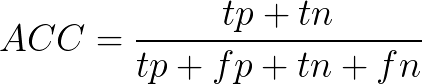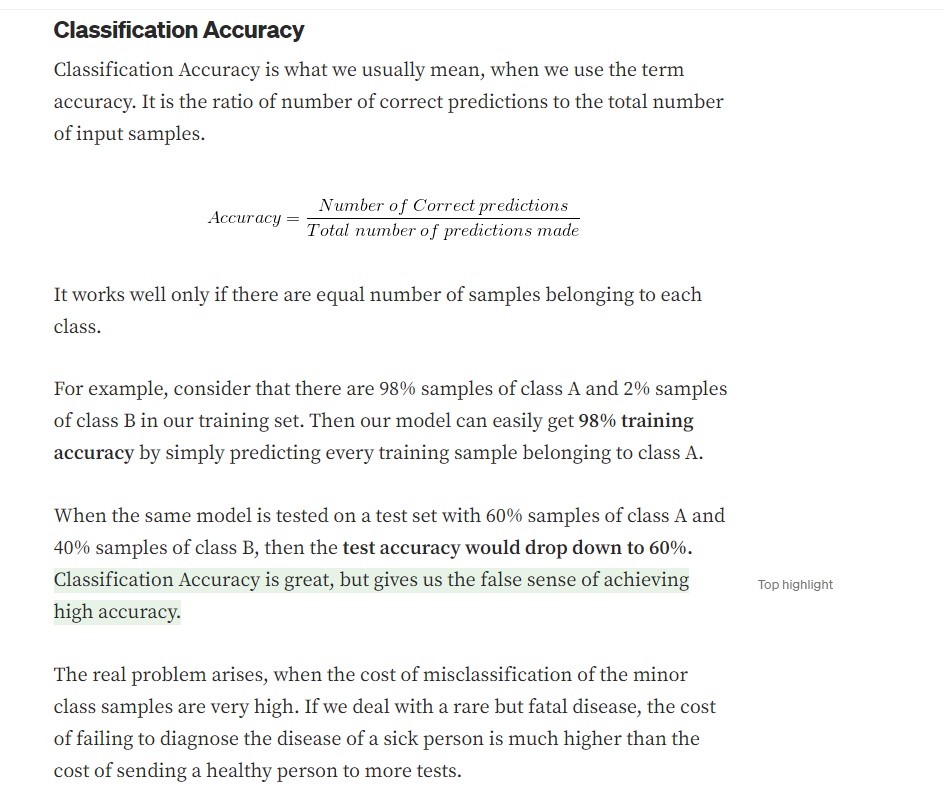

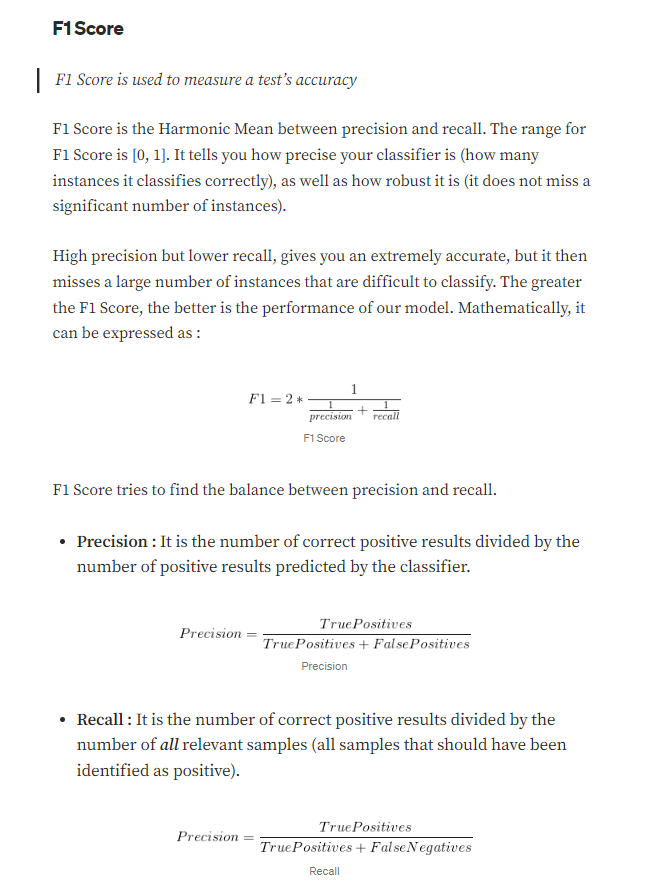

In [166]:
n = 100
tp,fill_success=check_test(masked_data=masked_test_corpus[0:n],data=test_corpus_copy[0:n],first_k_results=5,amount_data=n)
acc=tp/n
print(acc)

0.17


In [156]:
# n = len(masked_test_corpus)-1
# tp,fill_success=check_test(masked_data=masked_test_corpus[0:n],data=test_corpus_copy[0:n],first_k_results=5,amount_data=n)
# acc=tp/n
# print(acc)

0.4007989347536618


it seems like the training was good but not enough we were correct on the test only 36.5% need to pump those numbers up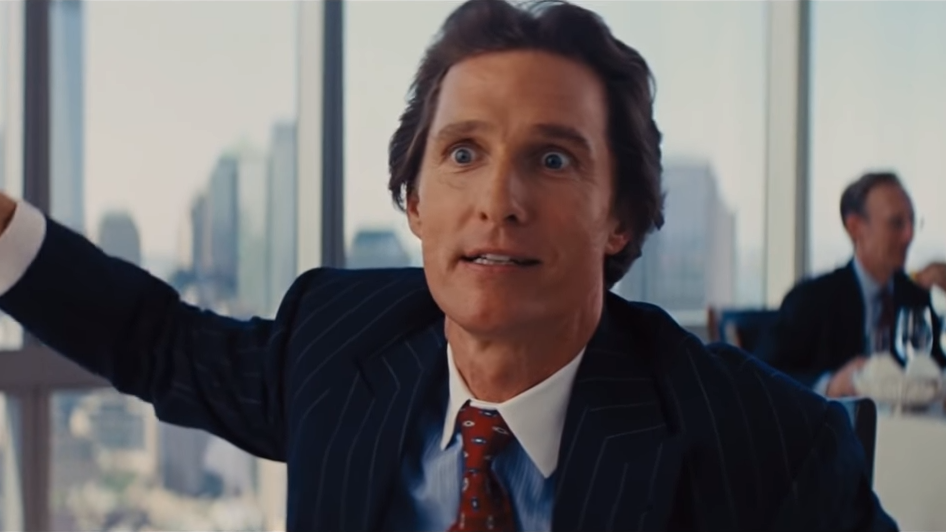

the code below is me trying to figure why can't i change the epoch, i thought i controled it but its the default from the pretrained model.changing the config file didn't help so goin to think of a diffrent approach

#next tasks

excel for ypredic results and %


In [173]:
import csv
def create_csv(test_corpus_copy,masked_test_corpus,fill_success,masked_word_array):
    # Sample data
    data=[]
    # print(masked_word_array)
    # print(fill_success)
    for index in range(len(test_corpus_copy)-1):
        # print(test_corpus_copy[index])
        # print(masked_test_corpus[index])
        # print(fill_success[0][index])
        
        sublist = []  # Create a new sublist for each index
        sublist.append(test_corpus_copy[index])

        sublist.append(masked_test_corpus[index])

        sublist.append(masked_word_array[index])

        # sublist.append(fill_success[0][index])

        data.append(sublist)

    # print(data[0])
    # print(data[1])
    # Specify the file name and mode ('w' for write)
    filename = 'tests_results.csv'
   
    # Open the file in write mode
    with open(filename, 'w', newline='') as csvfile:
        # Create a CSV writer object
        csvwriter = csv.writer(csvfile)

        # Write the data to the CSV file
        csvwriter.writerows(data)

    print(f'CSV file "{filename}" created successfully.')


create_csv(test_corpus_copy,masked_test_corpus,fill_success,masked_word_array)

CSV file "tests_results.csv" created successfully.


In [179]:

def add_column_to_csv(filename, column_data):
    # Read the existing data
    data = []
    with open(filename, 'r') as csvfile:
        csvreader = csv.reader(csvfile)
        data = list(csvreader)

    # Update the data with the new column
    for index in range(len(column_data)):
        data[index].append(column_data[index])

    # Write the updated data back to the file
    with open(filename, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerows(data)

# Example usage
filename = 'tests_results.csv'
column_data = fill_success[0]

add_column_to_csv(filename, column_data)

print(f'Column added to the CSV file "{filename}" successfully.')
filename = 'tests_results.csv'


# def add_column_to_csv(filename, data):
#     with open(filename, 'a', newline='') as csvfile:
#         csvwriter = csv.writer(csvfile)
#         csvwriter.writerow(data)

# # Example usage
# filename = 'tests_results.csv'
# column_data = fill_success[0]
# print(fill_success[0])

# add_column_to_csv(filename, column_data)

# print(f'Column added to the CSV file "{filename}" successfully.')


Column added to the CSV file "tests_results.csv" successfully.
["[' והנה המלאך הדבר בי יצא ומלאך אחר יצא לקראתו. ']", ' והנה המלאך הדבר בי יצא ומלאך אחר יצא לקראתו. [MASK]', '', '1.0', '1.0', '1.0']
["[' ויסגר לחרב עמו ובנחלתו התעבר. ']", '[MASK] ויסגר לחרב עמו ובנחלתו התעבר. ', '', '0.0', '0.0', '0.0']
["[' ובנביאי שמרון ראיתי תפלה הנבאו בבעל ויתעו את עמי את ישראל. ']", '[MASK] ובנביאי שמרון ראיתי תפלה הנבאו בבעל ויתעו את עמי את ישראל. ', '', '1.0', '1.0', '1.0']


In [180]:
def show_result_file():
    
    with open(filename, 'r') as csvfile:
        csvreader = csv.reader(csvfile)
        
        # Print the first three rows
        for index, row in enumerate(csvreader):
            if index < 3:
                print(row)
            else:
                break

alephbert with our corpus

In [181]:
model_name = "onlplab/alephbert-base"
train_model(model_name=model_name)


/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:119: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [182]:
save_total_limit='3'
path = "/content/drive/MyDrive/Colab Notebooks/Final_Project/trained_model"
os.path.isdir(path)
os.chdir(path=path)
print(os.listdir())
for i in range(len(os.listdir())-1):
    if "checkpoint-"+save_total_limit in os.listdir()[i]:
        path+='/'+os.listdir()[i]+'/'
if os.path.isdir(path):
    trained_model=path
    print(trained_model)

# path = "/content/drive/MyDrive/Colab Notebooks/Final_Project/trained_model"
# os.path.isdir(path)
# os.chdir(path=path)
# print(os.listdir())
# if os.listdir()[-1] == "HeBERT":
#     path+="/"+os.listdir()[-2]+"/"
# else:
#     path+="/"+os.listdir()[-1]+"/"
# print(path)

# if os.path.isdir(path):
#     trained_model=path

['runs', 'checkpoint-1', 'checkpoint-2', 'checkpoint-3', 'HeBERT', 'tests_results.csv']
/content/drive/MyDrive/Colab Notebooks/Final_Project/trained_model/checkpoint-3/


In [183]:
print(trained_model)

/content/drive/MyDrive/Colab Notebooks/Final_Project/trained_model/checkpoint-3/


In [184]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
config = AutoConfig.from_pretrained(model_name)

# Save the configuration file to disk
config.save_pretrained("/content/drive/MyDrive/Colab Notebooks/Final_Project/trained_model/HeBERT/config.json")
print(tokenizer)

BertTokenizerFast(name_or_path='onlplab/alephbert-base', vocab_size=52000, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)


In [185]:

fill_mask = pipeline(
    "fill-mask",
    model=trained_model,
    tokenizer=tokenizer,
)

In [186]:
# masked_test_corpus,masked_word_array=random_mask(test_corpus_copy)

In [187]:
n = 100
tp,fill_success=check_test(masked_data=masked_test_corpus[0:n],data=test_corpus_copy[0:n],first_k_results=5,amount_data=n)
acc=tp/n
print(acc)

0.43


Test normal Hebert with oscar and wiki

Test normal ALPHBERT oscar and wiki

Test normal GimelBERT and oscar and wiki

Add to oscar and wiki the bible corpus and repaet tests